# Generate Image Stack For Import In 3D Slicer
The main goal of this notebook is to generate black and white images of each slice and then import them into 3D slicer.

# Imports

In [1]:
import numpy as np
import scipy.io 
import pandas as  pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

# DB

In [3]:
workingDir = 'C:/Cerebral/_MarioSandBox/DB/medicalHolography/vascular/Example/'
dataName = 'VTD_ready_for_ROI_choice.mat'
maskName = 'mask.mat'

In [4]:
def readData(fileLocationAndName,VariableName):
    data = scipy.io.loadmat(fileLocationAndName)
    data = data[VariableName]
    dataArray = np.array(data)
    return dataArray

In [5]:
data = readData(workingDir+dataName,'VTD_ready')
data.shape

(360L, 766L, 760L)

In [6]:
mask = readData(workingDir+maskName,'mask')
mask.shape

(760L, 766L)

# Data Manipulation

In [7]:
def invertImages(stack):
    [slices,w,l] = np.shape(stack)
    invertedImages = np.zeros([slices,l,w])
    numSlices = np.shape(stack)[0]
    for sliceIndex in xrange(numSlices):        
        currentImage = np.fliplr(np.flipud(stack[sliceIndex].T))
        invertedImages[sliceIndex]= currentImage        
    return invertedImages    

# Visualization Functions

In [8]:
def drawSingleImage(stack):
    plt.figure()
    plt.imshow(stack)

In [9]:
def drawSlice(stack,sliceIndex):
    plt.figure()
    plt.imshow(stack[sliceIndex])

In [10]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='jet')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

# Mask Functions

In [11]:
def maskImageStack(stack,mask):    
    maskedImages = np.zeros(np.shape(stack))
    numSlices = np.shape(stack)[0]
    for sliceIndex in xrange(numSlices):
        currentImage = stack[sliceIndex]
        maskedImages[sliceIndex]= np.multiply(currentImage,mask)
    
    return maskedImages    

# Data visualization Functions
- [3D Plotting](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/)

In [12]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

import  plotly.plotly  as py
import plotly.graph_objs as go

In [13]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans

In [14]:
def make_mesh(image, threshold=-300, step_size=1):
    print "Transposing surface"
    p = image.transpose(2,1,0)
    
    print "Calculating surface"
    verts, faces = measure.marching_cubes(p, threshold) 
    #verts, faces, normals, values = measure.marching_cubes_lewiner(p, 0.0)
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print "Drawing"
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print "Drawing"
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    print 'generating poly3d'
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    print 'finished generating poly3d'
    face_color = [1, 1, 0.9]
    print 'adding some colour'
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    print 'setting limits'
    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    print 'adding some colour'
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    print 'showing'
    plt.show()
    print 'finished'

In [15]:
def myplotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print "Drawing"
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap="Portland",
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)


# Main Work

Before doing some mesh generation we need to massage the data such that it looks like the ones we see in the example folder that was given to us.

In [16]:
newData = invertImages(data)

Now let us apply the mask to this new data and then view it again.

In [17]:
maskedData = maskImageStack(newData,mask)

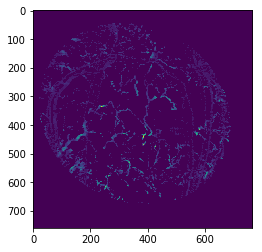

In [18]:
drawSingleImage(maskedData[105])

In [22]:
def getTHImageStack(stack):
    [s,l,w] = np.shape(stack)

    for sliceIndex in xrange(s):
        imgSlice = np.zeros([l,w])
        imgSlice = stack[sliceIndex,:,:]
        imgSlice[imgSlice>0]=255
        stack[sliceIndex,:,:] = imgSlice   
    return stack

In [23]:
thImageStack = getTHImageStack(maskedData)    

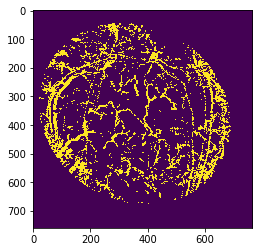

In [24]:
drawSingleImage(thImageStack[105])

Yes this is exactly what we are looking for.  We can perform some dilation and closing but let us use this for now.

# Generate Stack of Images

In [25]:
import scipy.misc as scioM

In [47]:
def saveImage(stack,saveDir,fileName):
    [s,l,w] = np.shape(stack)
    
    for imageSlice in xrange(s):
        if imageSlice<10:
            fileOut = saveDir+fileName+'00'+str(imageSlice)+'.png'
        elif imageSlice <100:
            fileOut = saveDir+fileName+'0'+str(imageSlice)+'.png'
        else:
            fileOut = saveDir+fileName+str(imageSlice)+'.png'
        print('Now creating: '+fileOut)
        
        scioM.imsave(fileOut,stack[imageSlice,:,:])        

In [48]:
saveDir = "C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/"
fileName = 'sliceImg_'

In [50]:
saveImage(thImageStack,saveDir,fileName)

Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_000.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_001.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_002.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_003.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_004.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_005.png


C:\Users\HP\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning:

`imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.



Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_006.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_007.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_008.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_009.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_010.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_011.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_012.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_013.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_014.png
Now creating: C:/Cerebral/_MarioSandBox/DB/med

Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_088.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_089.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_090.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_091.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_092.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_093.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_094.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_095.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_096.png
Now creating: C:/Cerebral/_MarioSandBox/DB/med

Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_171.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_172.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_173.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_174.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_175.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_176.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_177.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_178.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_179.png
Now creating: C:/Cerebral/_MarioSandBox/DB/med

Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_253.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_254.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_255.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_256.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_257.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_258.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_259.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_260.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_261.png
Now creating: C:/Cerebral/_MarioSandBox/DB/med

Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_332.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_333.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_334.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_335.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_336.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_337.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_338.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_339.png
Now creating: C:/Cerebral/_MarioSandBox/DB/medicalHolography/imgStacks/ThresholdedImages/sliceImg_340.png
Now creating: C:/Cerebral/_MarioSandBox/DB/med